# Clustering
This is the last topic worth trying in the scikit-learn package. After this, we move into Ensemble methods, and try out the cs109 homeworks. Those problems are to be solved from scratch by myself using python.
The general tools I know about clustering includes (1)K-means (2)Gaussian Mixture Methods (3) Hierarchical Clustering and (4) Spectral clustering. The last one is not covered in the elements of statistical learning book, but apparently scikit learn package provides a class for this algorithm.

## Gaussian Mixture Models
In the official documentation, this model has another chapter dedicated to it. Because of my current research, let's do this part more carefully.
A gaussian mixture model is a mixture of independent gaussian densities. The data points $x$ can be expressed to be following the density
$$ f(x) = \pi_1 f_1 + \pi_2 f_2 + ... + \pi_k f_k  $$
With each $f$ being a gaussian density function
$$ f_j(x) = \frac{1}{(2\pi)^{n}|\Sigma|^{n/2}} e^{-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu)  } $$
The parameters in all these densities can be either known of unknown for a gaussian mixture model.
The standard way of approaching solving this problem is the EM algorithm. The likelihood given the data points is maximized w.r.t all the parameters.
The data $x_1,x_2,...,x_n$ are assumed to be iid from the mixture density. Therefore, the likihood would be
$$  L(x;\theta) = \prod\limits_{i=1}^n f(x_i) $$
The log likelihood is then
$$ l(x;\theta) = \sum\limits_{i=1}^n log(f(x_i)) $$
The details of the derivation is omitted here. The EM method is an iterative algorithm where the 'weights' and parameters are iteratively updated until convergence is reached. 

## Gaussian Mixture Model Selection
This section is using the BIC model for choosing the correct number of components for a GMM. Full techniqual derivation can be found in the 1998 paper.

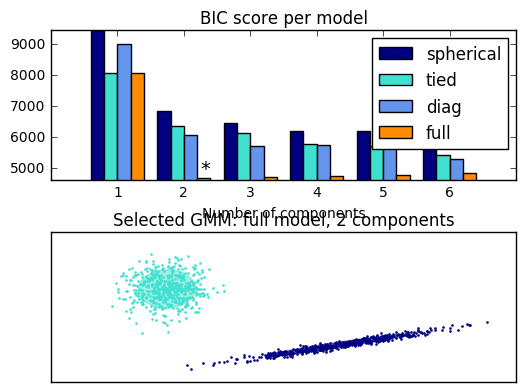

In [2]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture

n_samples = 500
np.random.seed(2016)
C = np.array([[0.,-0.1],[1.7,.4]])
X = np.r_[np.dot(np.random.randn(n_samples,2),C),
         .7*np.random.randn(n_samples,2)+np.array([-6,3])]

lowest_bic = np.infty
bic = []
n_components_range = range(1,7)
cv_types = ['spherical','tied','diag','full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components = n_components,covariance_type = cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1]< lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
bic = np.array(bic)
color_iter = itertools.cycle(['navy','turquoise','cornflowerblue','darkorange'])
clf = best_gmm
bars = []


# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## Variational Bayesian Gaussian Mixture
I see a lot of variational analysis when reading about mixture models, but did not really get a chance to fully internalize this concept. Now it is a good chance to do that.


[[ 0.  -0.1]
 [ 1.7 -0.4]]


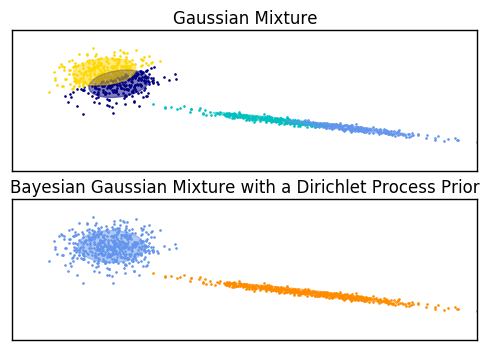

In [15]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

color_iter = itertools.cycle(['navy','c','cornflowerblue','gold','darkorange'])


# this plot function is taken directly from the official documentation in scikit-learn
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

n_samples = 500

np.random.seed(2016)
C = np.array([[0,-0.1],[1.7,-0.4]])
print(C)

X = np.r_[np.dot(np.random.randn(n_samples,2),C),.7*np.random.randn(n_samples,2)+np.array([-6,3])]

gmm = mixture.GaussianMixture(n_components = 4, covariance_type='full').fit(X)
plot_results(X,gmm.predict(X),gmm.means_,gmm.covariances_,0,'Gaussian Mixture')

dpgmm = mixture.BayesianGaussianMixture(n_components=5,covariance_type='full').fit(X)
plot_results(X,dpgmm.predict(X),dpgmm.means_,dpgmm.covariances_,1,'Bayesian Gaussian Mixture with a Dirichlet Process Prior')

plt.show()


The take-home information about the bayesian mixture model is that we have tools to decide the number of clusters in the gaussian mixture model. 

## K-means Clustering
This algorithm iteratively updates the centroid of each data and the distance from data points to each centroid.bb


# Spectral Clustering
I have read the 2007 paper very carefully. Spectral clustering is to cut the similarity graph with some size constraints. 
Here we use the example of treating the pixel values in an image, and the similarity distance is some image gradient which measures the change in pixel values. Then spectral clustering will give a nice segmentation of the image.

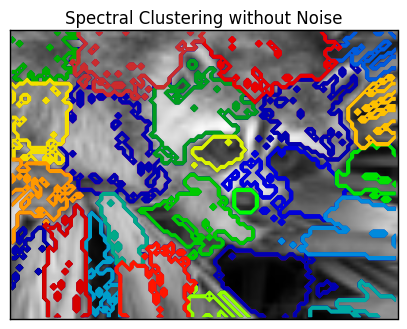

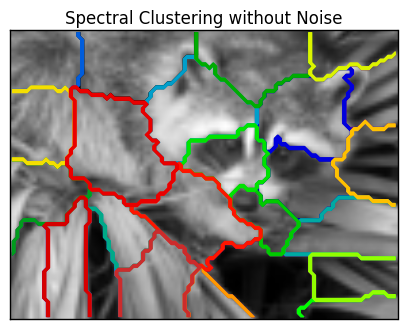

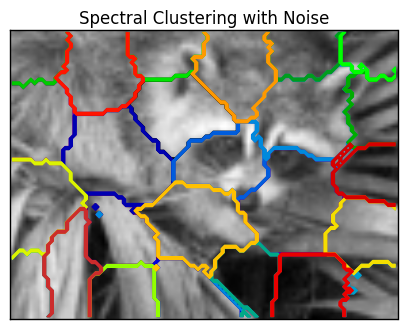

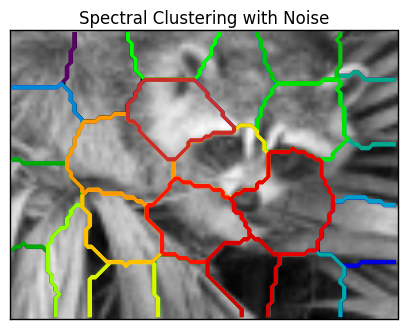

In [46]:
import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version
from scipy import misc

face = misc.face(gray=True)
# adding noise to the image to see how the method behaves
dnoise = 50*np.random.randn(face.shape[0],face.shape[1])
face_noise = face + dnoise

face = sp.misc.imresize(face,0.10)/255
face_noise = sp.misc.imresize(face_noise,0.10)/255


graph = image.img_to_graph(face)
graph_noise = image.img_to_graph(face_noise)

beta = 5
eps = 1e-6
graph.data = np.exp(-beta*graph.data/graph.data.std())+eps
graph_noise.data = np.exp(-beta*graph_noise.data/graph_noise.data.std())+eps

N_regions = 25

plt.close()

for assign_labels in ('kmeans','discretize'):
    labels = spectral_clustering(graph,n_clusters = N_regions,assign_labels = assign_labels,random_state = 1)
    #labels_noise = spectral_clustering(graph_noise,N_clusters = N_region,assign_labels = assign_labels,random_state = 1)
    labels = labels.reshape(face.shape)
    
    plt.figure(figsize=(5,5))
    plt.imshow(face,cmap=plt.cm.gray)
    for l in range(N_regions):
        plt.contour(labels == l, contours =1, colors = [ plt.cm.spectral(l/float(N_regions)) ])
        
    plt.xticks(())
    plt.yticks(())
    plt.title("Spectral Clustering without Noise")
    
plt.show()

plt.close()

for assign_labels in ('kmeans','discretize'):
    labels = spectral_clustering(graph_noise,n_clusters = N_regions,assign_labels = assign_labels, random_state = 1)
    labels = labels.reshape(face.shape)
    
    plt.figure(figsize=(5,5))
    plt.imshow(face_noise,cmap=plt.cm.gray)
    for l in range(N_regions):
        plt.contour(labels==l,contours=1,colors=[plt.cm.spectral(l/float(N_regions))])
        
    plt.xticks(())
    plt.yticks(())
    plt.title("Spectral Clustering with Noise")
    
plt.show()






The clustering result with and without noise are a little different. In face, giving some noise actually improved the image segmentation result. This is really really weird.

This pretty much ends the learning section for scikit-learn package. The most important methods are reviewed. The next thing to do is to work on the harvard cs109 courses, study ensemble methods and gets my hands 